<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"><strong>M2.879 · TFM - Área 2- Machine Learning</strong></p>
<p style="margin: 0; padding-top: 22px; text-align:right;"><strong>Predicción de errores en producción industrial de piezas</strong></p>
    <p style="margin: 0; text-align:right;"><strong>Lorenzo Mesa Morales</strong></p>
    <p style="margin: 0; text-align:right;">2019-2 · Máster universitario en Ciencia de datos (Data science)</p>
    <p style="margin: 0; text-align:right;">Nombre Consultor/a: Jerónimo Hernández González</p>
    <p style="margin: 0; text-align:right;">Nombre Profesor/a responsable de la asignatura: Jordi Casas Roma</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Implementación

El documento se estructura siguiendo la metodología CRISP-DM en las siguientes secciones:

 <ol start="1">
  <li>Carga del conjuntos de datos</li>
  <li>Análisis de los datos
  <li>Preparación de los datos</li>
    3.1 Valores nulos
    <br>3.2 Reduccion de dimensionalidad
    <br>3.3 Técnicas de muestreo
  <li>Modelado</li>
    4.1 Random Forest
    <br>4.2 eXtreme Gradient Boosting (XGBoost)
  <li>Evaluación</li>
    5.1 Combinación secuencial de modelos
 </ol>
   
Para ello vamos a necesitar las siguientes librerías:

In [1]:
import time
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)
import gc
from collections import Counter
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import StackingClassifier


# 1. Carga del conjunto de datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Dada la cantidad de recursos que consume la carga de los datos se procede a mostrar un resumen de los datos que contienen cada uno de los ficheros 
<a href="https://www.kaggle.com/c/bosch-production-line-performance/discussion/22908" title="Kaggle Discusion 22908">[Kaggle Discusion 22908]</a>
</div>

In [2]:
gc.collect()

def muestra_resumen(filename): 
    rowCount=0
    numberEmptyValues=0

    with open(filename, "rt") as csvfile:
        filereader = csv.reader(csvfile)
        for curRow in filereader:
            if rowCount == 0 :
                headerRow=curRow
                numberColumns=len(headerRow)
                emptyList=['']*numberColumns  # creamos una lista para las entradas vacías
                emptyCounter=Counter(emptyList)

            else:
                curCounter=Counter(curRow)
                diff = curCounter-emptyCounter  # creamos una lista de valores no vacíos

                numberNotEmpty=len(diff) # calculamos el tamaño de la lista
                numEmpty=numberColumns-numberNotEmpty 
                numberEmptyValues=numberEmptyValues+numEmpty


            rowCount=rowCount+1


    totalnumber=rowCount*numberColumns
    pctEmpty=100*numberEmptyValues/totalnumber

    print("fichero analizado       :",filename)
    print("número de filas         :",rowCount)
    print("número de columnas      :",numberColumns)
    print("número de valores vacíos:",numberEmptyValues)
    print("% de valores vacíos     :",pctEmpty)
   

In [3]:
filename="../data/train_numeric.csv"
muestra_resumen(filename)

fichero analizado       : train_numeric.csv
número de filas         : 1183748
número de columnas      : 970
número de valores vacíos: 1035542147
% de valores vacíos     : 90.18551446011652


In [4]:
filename="../data/train_categorical.csv"
muestra_resumen(filename)

fichero analizado       : ../data/train_categorical.csv
número de filas         : 1183748
número de columnas      : 2141
número de valores vacíos: 2531522206
% de valores vacíos     : 99.886274584961


In [5]:
filename="../data/train_date.csv"
muestra_resumen(filename)

fichero analizado       : ../data/train_date.csv
número de filas         : 1183748
número de columnas      : 1157
número de valores vacíos: 1360147063
% de valores vacíos     : 99.31006150778272


In [6]:
# Para simplificar el trabajo y por la limitación de recursos se utilizan únicamente con los datos de tipo numérico

# Se carga el conjunto de datos de entrenamiento de tipo numérico

# Se toma una muestra de 100 filas para determinar los dtypes.
df_sample = pd.read_csv('../data/train_numeric.csv', nrows=100)

# Se convierten a float32 para reducir el tamaño del dataset y optimizar los recursos
float_cols = [c for c in df_sample if df_sample[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_num = pd.read_csv('../data/train_numeric.csv', engine='c', dtype={c: np.float32 for c in float_cols})


In [7]:
# Se muestra información del conjunto de datos cargados
df_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F52,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F88,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,L0_S7_F138,L0_S7_F142,L0_S8_F144,L0_S8_F146,L0_S8_F149,L0_S9_F155,L0_S9_F160,L0_S9_F165,L0_S9_F170,L0_S9_F175,L0_S9_F180,L0_S9_F185,L0_S9_F190,L0_S9_F195,L0_S9_F200,L0_S9_F205,L0_S9_F210,L0_S10_F219,L0_S10_F224,L0_S10_F229,L0_S10_F234,L0_S10_F239,L0_S10_F244,L0_S10_F249,L0_S10_F254,L0_S10_F259,L0_S10_F264,L0_S10_F269,L0_S10_F274,L0_S11_F282,L0_S11_F286,L0_S11_F290,L0_S11_F294,L0_S11_F298,L0_S11_F302,L0_S11_F306,L0_S11_F310,L0_S11_F314,L0_S11_F318,L0_S11_F322,L0_S11_F326,L0_S12_F330,L0_S12_F332,L0_S12_F334,L0_S12_F336,L0_S12_F338,L0_S12_F340,L0_S12_F342,L0_S12_F344,L0_S12_F346,L0_S12_F348,L0_S12_F350,L0_S12_F352,L0_S13_F354,L0_S13_F356,L0_S14_F358,L0_S14_F362,L0_S14_F366,L0_S14_F370,L0_S14_F374,L0_S14_F378,L0_S14_F382,L0_S14_F386,L0_S14_F390,L0_S15_F394,L0_S15_F397,L0_S15_F400,L0_S15_F403,L0_S15_F406,L0_S15_F409,L0_S15_F412,L0_S15_F415,L0_S15_F418,L0_S16_F421,L0_S16_F426,L0_S17_F431,L0_S17_F433,L0_S18_F435,L0_S18_F439,L0_S18_F449,L0_S19_F453,L0_S19_F455,L0_S19_F459,L0_S20_F461,L0_S20_F463,L0_S20_F466,L0_S21_F472,L0_S21_F477,L0_S21_F482,L0_S21_F487,L0_S21_F492,L0_S21_F497,L0_S21_F502,L0_S21_F507,L0_S21_F512,L0_S21_F517,L0_S21_F522,L0_S21_F527,L0_S21_F532,L0_S21_F537,L0_S22_F546,L0_S22_F551,L0_S22_F556,L0_S22_F561,L0_S22_F566,L0_S22_F571,L0_S22_F576,L0_S22_F581,L0_S22_F586,L0_S22_F591,L0_S22_F596,L0_S22_F601,L0_S22_F606,L0_S22_F611,L0_S23_F619,L0_S23_F623,L0_S23_F627,L0_S23_F631,L0_S23_F635,L0_S23_F639,L0_S23_F643,L0_S23_F647,L0_S23_F651,L0_S23_F655,L0_S23_F659,L0_S23_F663,L0_S23_F667,L0_S23_F671,L1_S24_F679,L1_S24_F683,L1_S24_F687,L1_S24_F691,L1_S24_F700,L1_S24_F719,L1_S24_F728,L1_S24_F733,L1_S24_F746,L1_S24_F751,L1_S24_F756,L1_S24_F761,L1_S24_F766,L1_S24_F775,L1_S24_F780,L1_S24_F785,L1_S24_F790,L1_S24_F795,L1_S24_F800,L1_S24_F802,L1_S24_F806,L1_S24_F808,L1_S24_F810,L1_S24_F812,L1_S24_F814,L1_S24_F816,L1_S24_F829,L1_S24_F834,L1_S24_F839,L1_S24_F844,L1_S24_F857,L1_S24_F862,L1_S24_F867,L1_S24_F872,L1_S24_F877,L1_S24_F882,L1_S24_F887,L1_S24_F892,L1_S24_F897,L1_S24_F902,L1_S24_F907,L1_S24_F920,L1_S24_F925,L1_S24_F930,L1_S24_F935,L1_S24_F948,L1_S24_F953,L1_S24_F958,L1_S24_F963,L1_S24_F968,L1_S24_F973,L1_S24_F978,L1_S24_F983,L1_S24_F988,L1_S24_F993,L1_S24_F998,L1_S24_F1000,L1_S24_F1002,L1_S24_F1004,L1_S24_F1006,L1_S24_F1008,L1_S24_F1010,L1_S24_F1012,L1_S24_F1014,L1_S24_F1016,L1_S24_F1021,L1_S24_F1026,L1_S24_F1031,L1_S24_F1036,L1_S24_F1041,L1_S24_F1046,L1_S24_F1051,L1_S24_F1056,L1_S24_F1068,L1_S24_F1072,L1_S24_F1079,L1_S24_F1083,L1_S24_F1087,L1_S24_F1094,L1_S24_F1098,L1_S24_F1102,L1_S24_F1106,L1_S24_F1110,L1_S24_F1118,L1_S24_F1122,L1_S24_F1126,L1_S24_F1130,L1_S24_F1134,L1_S24_F1145,L1_S24_F1148,L1_S24_F1161,L1_S24_F1166,L1_S24_F1170,L1_S24_F1172,L1_S24_F1174,L1_S24_F1176,L1_S24_F1180,L1_S24_F1184,L1_S24_F1197,L1_S24_F1202,L1_S24_F1207,L1_S24_F1212,L1_S24_F1225,L1_S24_F1230,L1_S24_F1235,L1_S24_F1240,L1_S24_F1245,L1_S24_F1250,L1_S24_F1255,L1_S24_F1260,L1_S24_F1265,L1_S24_F1270,L1_S24_F1275,L1_S24_F1288,L1_S24_F1293,L1_S24_F1298,L1_S24_F1303,L1_S24_F1316,L1_S24_F1321,L1_S24_F1326,L1_S24_F1331,L1_S24_F1336,L1_S24_F1341,L1_S24_F1346,L1_S24_F1351,L1_S24_F1356,L1_S24_F1361,L1_S24_F1366,L1_S24_F1371,L1_S24_F1376,L1_S24_F1381,L1_S24_F1386,L1_S24_F1391,L1_S24_F1396,L1_S24_F1401,L1_S24_F1406,L1_S24_F1411,L1_S24_F1416,L1_S24_F1421,L1_S24_F1426,L1_S24_F1431,L1_S24_F1436,L1_S24_F1441,L1_S24_F1446,L1_S24_F1451,L1_S24_F1463,L1_S24_F1467,L1_S24_F1474,L1_S24_F1478,L1_S24_F1482,L1_S24_F1486,L1_S24_F1490,L1_S24_F1494,L1_S24_F1498,L1_S24_F1502,L1_S24_F1506,L1_S24_F1512,L1_S24_F1514,L1_S24_F1516,L1_S24_F1518,L1_S24_F1520,L1_S24_F1539,L1_S24_F1544,L1_S24_F15

In [8]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183747 entries, 0 to 1183746
Columns: 970 entries, Id to Response
dtypes: float32(968), int64(2)
memory usage: 4.3 GB


In [9]:
df_num.shape

(1183747, 970)

In [10]:
df_num.dtypes

Id                int64
L0_S0_F0        float32
L0_S0_F2        float32
L0_S0_F4        float32
L0_S0_F6        float32
                 ...   
L3_S51_F4256    float32
L3_S51_F4258    float32
L3_S51_F4260    float32
L3_S51_F4262    float32
Response          int64
Length: 970, dtype: object

In [11]:
summary = df_num.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
Id,1183747.0,1.184050e+06,683434.767725,4.000,592138.500,1184628.000,1775674.500,2367495.000
L0_S0_F0,673862.0,5.457200e-05,0.080215,-0.565,-0.049,0.003,0.056,0.278
L0_S0_F2,673862.0,9.128766e-05,0.092711,-0.616,-0.056,0.004,0.063,0.302
L0_S0_F4,673862.0,3.983363e-05,0.211498,-0.415,-0.179,-0.033,0.294,0.585
L0_S0_F6,673862.0,1.392908e-05,0.211654,-0.416,-0.179,-0.034,0.294,0.584
...,...,...,...,...,...,...,...,...
L3_S51_F4256,59853.0,-2.171995e-06,0.000716,-0.001,0.000,0.000,0.000,0.173
L3_S51_F4258,59853.0,3.732479e-05,0.005785,0.000,0.000,0.000,0.000,1.000
L3_S51_F4260,59853.0,2.160626e-04,0.008293,0.000,0.000,0.000,0.000,1.000
L3_S51_F4262,59853.0,5.627102e-05,0.004196,0.000,0.000,0.000,0.000,1.000


In [12]:
# Dada la cantidad de recursos que consume la carga del conjunto de datos de entrenamiento de tipo categórico
# solo se leen los 10000 primeros registros para realizar un análisis rápido

df_categ = pd.read_csv('../data/train_categorical.csv', nrows=10000 ,low_memory=False)


In [13]:
df_categ.head()

Id L0_S1_F25 L0_S1_F27 L0_S1_F29 L0_S1_F31 L0_S2_F33 L0_S2_F35 L0_S2_F37  \
0   4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1   6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2   7       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3   9       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4  11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

  L0_S2_F39 L0_S2_F41 L0_S2_F43 L0_S2_F45 L0_S2_F47 L0_S2_F49 L0_S2_F51  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

  L0_S2_F53 L0_S2_F55 L0_S2_F57 L0_S2_F59 L0_S2_F61 L0_S2_F63 L0_S2_F65  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

  L0_S2_F67  L0_S3_F69  L0_S3_F71  L0_S3_F73  L0_S3_F75  L0_S3_F77  L0_S3_F79  \
0       NaN        NaN        NaN        NaN        NaN        NaN        NaN   
1       NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2       NaN        NaN        NaN        NaN        NaN        NaN        NaN   
3       NaN        NaN        NaN        NaN        NaN        NaN        NaN   
4       NaN        NaN        NaN        NaN        NaN        NaN        NaN   

   L0_S3_F81  L0_S3_F83  L0_S3_F85  L0_S3_F87  L0_S3_F89  L0_S3_F91  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   L0_S3_F93  L0_S3_F95  L0_S3_F97  L0_S3_F99  L0_S3_F101  L0_S3_F103  \
0        NaN        NaN        NaN        NaN         NaN         NaN   
1        NaN        NaN        NaN        NaN         NaN         NaN   
2        NaN        NaN        NaN        NaN         NaN         NaN   
3        NaN        NaN        NaN        NaN         NaN         NaN   
4        NaN        NaN        NaN        NaN         NaN         NaN   

  L0_S4_F105 L0_S4_F107 L0_S4_F108  L0_S4_F110  L0_S4_F112  L0_S4_F113  \
0        NaN        NaN        NaN         NaN         NaN         NaN   
1        NaN        NaN        NaN         NaN         NaN         NaN   
2        NaN        NaN        NaN         NaN         NaN         NaN   
3        NaN        NaN        NaN         NaN         NaN         NaN   
4        NaN        NaN        NaN         NaN         NaN         NaN   

   L0_S6_F119  L0_S6_F121  L0_S6_F123  L0_S6_F125  L0_S6_F126  L0_S6_F128  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   L0_S6_F129  L0_S6_F131  L0_S6_F133  L0_S6_F135 L0_S9_F151  L0_S9_F153  \
0         NaN         NaN         NaN         NaN        NaN         NaN   
1         NaN         NaN         NaN         NaN        NaN         NaN   
2         NaN         NaN         NaN         NaN        NaN         NaN   
3         NaN         NaN         NaN         NaN        NaN 

In [14]:
df_categ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 2141 entries, Id to L3_S49_F4240
dtypes: float64(1375), int64(1), object(765)
memory usage: 163.3+ MB


In [15]:
summary = df_categ.describe()
summary = summary.transpose()
summary


,count,mean,std,min,25%,50%,75%,max
Id,10000.0,9959.5985,5722.930873,4.0,5035.5,9974.5,14896.25,19923.0
L0_S3_F69,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S3_F71,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S3_F73,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S3_F75,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
L3_S49_F4234,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4235,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4239,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Dada la cantidad de recursos que consume la carga de del conjunto de datos de entrenamiento de tipo categórico
# solo se leen los 10000 primeros registros para realizar un análisis rápido

df_date = pd.read_csv('../data/train_date.csv', nrows=10000 ,low_memory=False)

In [17]:
df_date.head()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,L0_S0_D21,L0_S0_D23,L0_S1_D26,L0_S1_D30,L0_S2_D34,L0_S2_D38,L0_S2_D42,L0_S2_D46,L0_S2_D50,L0_S2_D54,L0_S2_D58,L0_S2_D62,L0_S2_D66,L0_S3_D70,L0_S3_D74,L0_S3_D78,L0_S3_D82,L0_S3_D86,L0_S3_D90,L0_S3_D94,L0_S3_D98,L0_S3_D102,L0_S4_D106,L0_S4_D111,L0_S5_D115,L0_S5_D117,L0_S6_D120,L0_S6_D124,L0_S6_D127,L0_S6_D130,L0_S6_D134,L0_S7_D137,L0_S7_D139,L0_S7_D140,L0_S7_D141,L0_S7_D143,L0_S8_D145,L0_S8_D147,L0_S8_D148,L0_S8_D150,L0_S9_D152,L0_S9_D157,L0_S9_D162,L0_S9_D167,L0_S9_D172,L0_S9_D177,L0_S9_D182,L0_S9_D187,L0_S9_D192,L0_S9_D197,L0_S9_D202,L0_S9_D207,L0_S9_D212,L0_S10_D216,L0_S10_D221,L0_S10_D226,L0_S10_D231,L0_S10_D236,L0_S10_D241,L0_S10_D246,L0_S10_D251,L0_S10_D256,L0_S10_D261,L0_S10_D266,L0_S10_D271,L0_S10_D276,L0_S11_D280,L0_S11_D284,L0_S11_D288,L0_S11_D292,L0_S11_D296,L0_S11_D300,L0_S11_D304,L0_S11_D308,L0_S11_D312,L0_S11_D316,L0_S11_D320,L0_S11_D324,L0_S11_D328,L0_S12_D331,L0_S12_D333,L0_S12_D335,L0_S12_D337,L0_S12_D339,L0_S12_D341,L0_S12_D343,L0_S12_D345,L0_S12_D347,L0_S12_D349,L0_S12_D351,L0_S12_D353,L0_S13_D355,L0_S13_D357,L0_S14_D360,L0_S14_D364,L0_S14_D368,L0_S14_D372,L0_S14_D376,L0_S14_D380,L0_S14_D384,L0_S14_D388,L0_S14_D392,L0_S15_D395,L0_S15_D398,L0_S15_D401,L0_S15_D404,L0_S15_D407,L0_S15_D410,L0_S15_D413,L0_S15_D416,L0_S15_D419,L0_S16_D423,L0_S16_D428,L0_S17_D432,L0_S17_D434,L0_S18_D437,L0_S18_D441,L0_S18_D444,L0_S18_D447,L0_S18_D451,L0_S19_D454,L0_S19_D456,L0_S19_D457,L0_S19_D458,L0_S19_D460,L0_S20_D462,L0_S20_D464,L0_S20_D465,L0_S20_D467,L0_S21_D469,L0_S21_D474,L0_S21_D479,L0_S21_D484,L0_S21_D489,L0_S21_D494,L0_S21_D499,L0_S21_D504,L0_S21_D509,L0_S21_D514,L0_S21_D519,L0_S21_D524,L0_S21_D529,L0_S21_D534,L0_S21_D539,L0_S22_D543,L0_S22_D548,L0_S22_D553,L0_S22_D558,L0_S22_D563,L0_S22_D568,L0_S22_D573,L0_S22_D578,L0_S22_D583,L0_S22_D588,L0_S22_D593,L0_S22_D598,L0_S22_D603,L0_S22_D608,L0_S22_D613,L0_S23_D617,L0_S23_D621,L0_S23_D625,L0_S23_D629,L0_S23_D633,L0_S23_D637,L0_S23_D641,L0_S23_D645,L0_S23_D649,L0_S23_D653,L0_S23_D657,L0_S23_D661,L0_S23_D665,L0_S23_D669,L0_S23_D673,L1_S24_D677,L1_S24_D681,L1_S24_D685,L1_S24_D689,L1_S24_D693,L1_S24_D697,L1_S24_D702,L1_S24_D707,L1_S24_D712,L1_S24_D716,L1_S24_D721,L1_S24_D725,L1_S24_D730,L1_S24_D735,L1_S24_D739,L1_S24_D743,L1_S24_D748,L1_S24_D753,L1_S24_D758,L1_S24_D763,L1_S24_D768,L1_S24_D772,L1_S24_D777,L1_S24_D782,L1_S24_D787,L1_S24_D792,L1_S24_D797,L1_S24_D801,L1_S24_D804,L1_S24_D807,L1_S24_D809,L1_S24_D811,L1_S24_D813,L1_S24_D815,L1_S24_D818,L1_S24_D822,L1_S24_D826,L1_S24_D831,L1_S24_D836,L1_S24_D841,L1_S24_D846,L1_S24_D850,L1_S24_D854,L1_S24_D859,L1_S24_D864,L1_S24_D869,L1_S24_D874,L1_S24_D879,L1_S24_D884,L1_S24_D889,L1_S24_D894,L1_S24_D899,L1_S24_D904,L1_S24_D909,L1_S24_D913,L1_S24_D917,L1_S24_D922,L1_S24_D927,L1_S24_D932,L1_S24_D937,L1_S24_D941,L1_S24_D945,L1_S24_D950,L1_S24_D955,L1_S24_D960,L1_S24_D965,L1_S24_D970,L1_S24_D975,L1_S24_D980,L1_S24_D985,L1_S24_D990,L1_S24_D995,L1_S24_D999,L1_S24_D1001,L1_S24_D1003,L1_S24_D1005,L1_S24_D1007,L1_S24_D1009,L1_S24_D1011,L1_S24_D1013,L1_S24_D1015,L1_S24_D1018,L1_S24_D1023,L1_S24_D1028,L1_S24_D1033,L1_S24_D1038,L1_S24_D1043,L1_S24_D1048,L1_S24_D1053,L1_S24_D1058,L1_S24_D1062,L1_S24_D1066,L1_S24_D1070,L1_S24_D1074,L1_S24_D1077,L1_S24_D1081,L1_S24_D1085,L1_S24_D1089,L1_S24_D1092,L1_S24_D1096,L1_S24_D1100,L1_S24_D1104,L1_S24_D1108,L1_S24_D1112,L1_S24_D1116,L1_S24_D1120,L1_S24_D1124,L1_S24_D1128,L1_S24_D1132,L1_S24_D1135,L1_S24_D1138,L1_S24_D1141,L1_S24_D1143,L1_S24_D1146,L1_S24_D1149,L1_S24_D1151,L1_S24_D1153,L1_S24_D1155,L1_S24_D1158,L1_S24_D1163,L1_S24_D1168,L1_S24_D1171,L1_S24_D1173,L1_S24_D1175,L1_S24_D1178,L1_S24_D1182,L1_S24_D1186,L1_S24_D1190,L1_S24_D1194,L1_S24_D1199,L1_S24_D1204,L1_S24_D1209,L1_S24_D1214,L1_S24_D1218,L1_S24_D1222,L1_S24_D1227,L1_S24_D1232,L1_S24_D1237,L1_S24_D1242,L1_S24_D1247,L1_S24_D1252,L1_S24_D1257,L1_S24_D1262,L1_S24_D1267,L1_S24_D1272,L1_S24_D1277,L1_S24_D1281,L1_S24_D1285,L1_S24_D1290,L1_S24_D1295,L1_S24_D13

In [18]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1157 entries, Id to L3_S51_D4263
dtypes: float64(1156), int64(1)
memory usage: 88.3 MB


In [19]:
summary = df_date.describe()
summary = summary.transpose()
summary


,count,mean,std,min,25%,50%,75%,max
Id,10000.0,9959.598500,5722.930873,4.00,5035.50,9974.50,14896.25,19923.00
L0_S0_D1,5733.0,885.967705,501.255937,0.82,490.03,913.20,1365.34,1711.20
L0_S0_D3,5733.0,885.967705,501.255937,0.82,490.03,913.20,1365.34,1711.20
L0_S0_D5,5733.0,885.967705,501.255937,0.82,490.03,913.20,1365.34,1711.20
L0_S0_D7,5733.0,885.967705,501.255937,0.82,490.03,913.20,1365.34,1711.20
...,...,...,...,...,...,...,...,...
L3_S51_D4255,501.0,1060.375649,404.237831,114.66,577.03,1291.65,1408.32,1457.48
L3_S51_D4257,501.0,1060.375649,404.237831,114.66,577.03,1291.65,1408.32,1457.48
L3_S51_D4259,501.0,1060.375649,404.237831,114.66,577.03,1291.65,1408.32,1457.48
L3_S51_D4261,501.0,1060.375649,404.237831,114.66,577.03,1291.65,1408.32,1457.48


# 2. Análisis de los datos

In [20]:
# Se muestra un análisis estadístico para los atributos numéricos
df_num.describe()

Id       L0_S0_F0       L0_S0_F2       L0_S0_F4  \
count  1.183747e+06  673862.000000  673862.000000  673862.000000   
mean   1.184050e+06       0.000055       0.000091       0.000040   
std    6.834348e+05       0.080215       0.092711       0.211498   
min    4.000000e+00      -0.565000      -0.616000      -0.415000   
25%    5.921385e+05      -0.049000      -0.056000      -0.179000   
50%    1.184628e+06       0.003000       0.004000      -0.033000   
75%    1.775674e+06       0.056000       0.063000       0.294000   
max    2.367495e+06       0.278000       0.302000       0.585000   

            L0_S0_F6       L0_S0_F8      L0_S0_F10      L0_S0_F12  \
count  673862.000000  673862.000000  673862.000000  673862.000000   
mean        0.000014      -0.000126       0.000161      -0.000044   
std         0.211654       0.094506       0.164301       0.019467   
min        -0.416000      -0.447000      -0.612000      -0.052000   
25%        -0.179000      -0.056000      -0.066000      -0.015000   
50%        -0.034000       0.031000       0.070000       0.000000   
75%         0.294000       0.074000       0.116000       0.015000   
max         0.584000       0.466000       0.388000       0.948000   

           L0_S0_F14     L0_S0_F16      L0_S0_F18      L0_S0_F20  \
count  673862.000000  6.738620e+05  673862.000000  673862.000000   
mean       -0.000359  4.423334e-07       0.000005       0.000286   
std         0.104276  1.148017e-01       0.112460       0.202804   
min        -0.272000 -5.000000e-01      -0.436000      -0.341000   
25%        -0.072000 -8.200000e-02      -0.078000      -0.175000   
50%        -0.032000  0.000000e+00       0.002000      -0.003000   
75%         0.088000  7.600000e-02       0.077000       0.167000   
max         0.688000  5.000000e-01       0.564000       0.659000   

           L0_S0_F22      L0_S1_F24      L0_S1_F28      L0_S2_F32  \
count  673862.000000  673902.000000  673904.000000  339774.000000   
mean        0.000286       0.000062      -0.000166      -0.000032   
std         0.202786       0.103005       0.107180       0.055065   
min        -0.341000      -0.404000      -0.408000      -0.213000   
25%        -0.175000      -0.069000      -0.075000      -0.013000   
50%        -0.003000      -0.007000      -0.013000      -0.013000   
75%         0.167000       0.078000       0.064000      -0.013000   
max         0.659000       0.588000       0.561000       0.787000   

           L0_S2_F36      L0_S2_F40      L0_S2_F44      L0_S2_F48  \
count  339774.000000  339774.000000  339774.000000  339774.000000   
mean        0.000441      -0.000091       0.000643      -0.000026   
std         0.195338       0.072214       0.266095       0.011336   
min        -0.308000      -0.192000      -0.373000      -0.984000   
25%        -0.133000      -0.092000      -0.216000      -0.002000   
50%        -0.060000       0.008000      -0.113000       0.001000   
75%         0.059000       0.008000       0.186000       0.003000   
max         0.692000       0.808000       0.627000       0.016000   

           L0_S2_F52      L0_S2_F56      L0_S2_F60      L0_S2_F64  \
count  339774.000000  339774.000000  339774.000000  339774.000000   
mean       -0.000085       0.000245       0.000470      -0.000056   
std         0.009238       0.061055       0.270081       0.060024   
min        -1.000000      -0.190000      -0.365000      -0.176000   
25%         0.000000       0.010000      -0.215000      -0.060000   
50%         0.000000       0.010000      -0.120000       0.000000   
75%         0.000000       0.010000       0.194000       0.055000   
max         0.000000       0.810000       0.634000       0.786000   

           L0_S3_F68      L0_S3_F72      L0_S3_F76      L0_S3_F80  \
count  334708.000000  334708.000000  334708.000000  334708.000000   
mean       -0.000311      -0.000009       0.000440      -0.000106   
std         0.047303       0.255317       0.055313       0.265372   
min        -0.191000      -

In [21]:
# Se calcula el porcentaje de resultados de piezas correctas e incorrectas en los datos:
df_num["Response"].value_counts(normalize=True)

0    0.994189
1    0.005811
Name: Response, dtype: float64

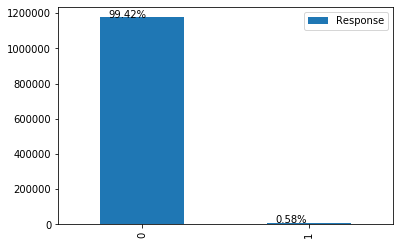

In [22]:
# Se muestra en formato gráfico la distribución de los resultados para evidenciar el desbalanceo en los datos

ax = df_num["Response"].value_counts().to_frame().plot(kind='bar')

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10)

# 3. Preparación de los datos

## 3.1 Valores nulos

In [23]:
# Se sustituyen los valores nulos por la media en los datos
df_num.fillna(df_num.mean(), inplace=True)


## 3.2 Reducción de dimensionalidad

In [24]:
# Se separan los datos entre las variables independientes y la variable dependiente
X = df_num.drop('Response',1)
y = df_num['Response']

# Se separan el conjunto en datos de entrenamiento (80%) y datos de test (20%) 
# Debido a la baja representación de casos de fallos, se utiliza el parámetro stratify para asegurar que 
# ambas clases están representadas en el conjunto de datos de test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)


In [25]:
# A continuación, se normalizan ambos conjuntos de datos para que estén representados en la misma escala 
# y por lo tanto no tomen más importancia unos que otros.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
X_train.shape

(946997, 969)

In [27]:
X_test.shape

(236750, 969)

In [28]:
y_train.shape

(946997,)

In [29]:
y_test.shape

(236750,)

### 3.2.1. PCA

In [30]:
# Se aplica la reducción de dimensionalidad tanto a los datos de entrenamiento como a los de test
# Se utiliza como parámetro un 98% de explicación de la varianza en lugar de determinar los componentes
pca = PCA(0.98)


In [31]:
# Se aplica el mapeo al conjunto de datos de entrenamiento
X_train_pca = pca.fit_transform(X_train)

In [32]:
# Se muestra el número de componentes calculado para al 98% de explicación de la varianza
print ( "Componentes para un 98% de explicación de varianza:   ", pca.n_components_ )

Componentes para un 98% de explicación de varianza:    630


In [33]:
# Se aplica el mapeo al conjunto de datos de test
X_test_pca = pca.transform(X_test)

In [34]:
X_train_pca.shape

(946997, 630)

In [35]:
X_test_pca.shape

(236750, 630)

### 3.2.2. Feature Importance

In [36]:
# Se utiliza el modelo XGBoost para obtener las características importantes
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

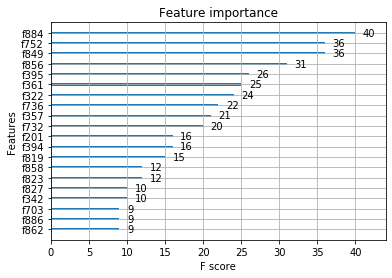

In [37]:
# Se muestra gráficamente el top 20 de características más importantes
plot_importance(xgb_model,max_num_features = 20)
plt.show()

In [38]:
# Se toman las 500 características más importantes para el conjunto de datos
selection = SelectFromModel(xgb_model, threshold=-np.inf, max_features=500, prefit=True)
X_train_xgb = selection.transform(X_train)
X_test_xgb = selection.transform(X_test)

In [39]:
X_train_xgb.shape

(946997, 500)

In [40]:
X_test_xgb.shape

(236750, 500)

## 3.3 Técnicas de muestreo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Se aplican las técnicas de muestreo sobre los datos obtenidos con la aplicación del PCA
</div>

In [41]:
rus_pca = RandomUnderSampler(random_state=2020)
X_train_rus_pca, y_train_rus_pca = rus_pca.fit_resample(X_train_pca, y_train)

In [42]:
sm_pca = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_sm_pca, y_train_sm_pca = sm_pca.fit_resample(X_train_pca, y_train)

In [43]:
y_vals, counts = np.unique(y_test, return_counts=True)

y_vals_rus_pca, counts_rus_pca = np.unique(y_train_rus_pca, return_counts=True)
y_vals_sm_pca, counts_sm_pca = np.unique(y_train_sm_pca, return_counts=True)

print('Clases en conjunto de entrenamiento:',dict(zip(y_vals, counts)),'\n',
      'Clases en conjunto de entrenamiento con PCA y RandomUnderSampler:',dict(zip(y_vals_rus_pca, counts_rus_pca)),'\n',
      'Clases en conjunto de entrenamiento con PCA y SMOTE:',dict(zip(y_vals_sm_pca, counts_sm_pca)),'\n',
     )

Clases en conjunto de entrenamiento: {0: 235374, 1: 1376} 
 Clases en conjunto de entrenamiento con PCA y RandomUnderSampler: {0: 5503, 1: 5503} 
 Clases en conjunto de entrenamiento con PCA y SMOTE: {0: 941494, 1: 941494} 



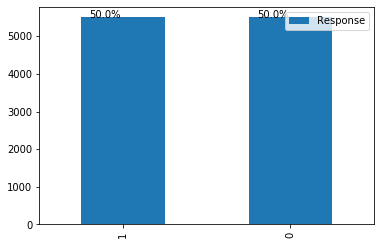

In [44]:
# Formato gráfico para evidenciar la corrección del desbalanceo en los datos de PCA y uno de los métodos

ax = y_train_rus_pca.value_counts().to_frame().plot(kind='bar')

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10)

In [45]:
X_train_rus_pca.shape

(11006, 630)

In [46]:
X_train_sm_pca.shape

(1882988, 630)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Se aplican las técnicas de muestreo sobre los datos obtenidos con la aplicación del XGBoost
</div>

In [47]:
rus_xgb = RandomUnderSampler(random_state=2020)
X_train_rus_xgb, y_train_rus_xgb = rus_xgb.fit_resample(X_train_xgb, y_train)

In [48]:
sm_xgb = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_sm_xgb, y_train_sm_xgb = sm_xgb.fit_resample(X_train_xgb, y_train)

In [49]:
y_vals_rus_xgb, counts_rus_xgb = np.unique(y_train_rus_xgb, return_counts=True)
y_vals_sm_xgb, counts_sm_xgb = np.unique(y_train_sm_xgb, return_counts=True)

print('Clases en conjunto de entrenamiento:',dict(zip(y_vals, counts)),'\n',
      'Clases en conjunto de entrenamiento con XGB y RandomUnderSampler:',dict(zip(y_vals_rus_xgb, counts_rus_xgb)),'\n',
      'Clases en conjunto de entrenamiento con XGB y SMOTE:',dict(zip(y_vals_sm_xgb, counts_sm_xgb)),'\n',
     )

Clases en conjunto de entrenamiento: {0: 235374, 1: 1376} 
 Clases en conjunto de entrenamiento con XGB y RandomUnderSampler: {0: 5503, 1: 5503} 
 Clases en conjunto de entrenamiento con XGB y SMOTE: {0: 941494, 1: 941494} 



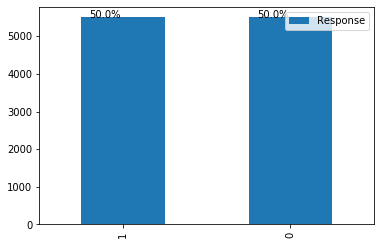

In [50]:
# Formato gráfico para evidenciar la corrección del desbalanceo en los datos de XGBoost y uno de los métodos

ax = y_train_rus_xgb.value_counts().to_frame().plot(kind='bar')

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10)

In [51]:
X_train_rus_xgb.shape

(11006, 500)

In [52]:
X_train_sm_xgb.shape

(1882988, 500)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Dada la gran cantidad de registros obtenidos en los metodos de sobremuestreo, antes de pasar al modelado, vamos a analizar si realmente necesitamos tantos datos.

Para ello se realiza el siguiente análisis:
<ul>
<li>Submuestreo aleatorio de la clase negativa con diferentes tamaños respecto a los casos positivos (1:2, 1:5, 1:10, 1:15)</li>
<li>A continuación, aplicar sobremuestreo de la clase negativa y aprender un modelo</li>
</ul>    
    
Este análisis se realiza con 10 submuestreos aleatorios diferentes para evitar sesgo en las muestras.
</div>

In [53]:
#TO-DO. Revisar y mejorar disposición del código
start_time = time.time()
ratios=[1/2, 1/5, 1/10, 1/15]
for ratio in ratios:
    acc_scores    = []
    prec_scores   = []
    recall_scores = []
    f1_scores     = []
    mcc_scores    = [] 
    for i in range(10):
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=i)
        X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado submuestreo: {}\n".format(1/ratio, i, X_train_rus.shape))
        sm = SMOTE(sampling_strategy='minority',random_state=i)
        X_train_rus_sm, y_train_rus_sm = sm.fit_resample(X_train_rus, y_train_rus)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado sobremuestreo: {}\n".format(1/ratio, i, X_train_rus_sm.shape))
        rf_clf_rus_sm = ensemble.RandomForestClassifier(n_estimators=50, random_state=i, n_jobs=3)
        rf_clf_rus_sm_pca = rf_clf_rus_sm.fit(X_train_rus_sm, y_train_rus_sm)
        y_pred_rf_rus_sm_pca = rf_clf_rus_sm_pca.predict(X_test_pca)
        acc = accuracy_score(y_test,y_pred_rf_rus_sm_pca)*100
        prec = precision_score(y_test,y_pred_rf_rus_sm_pca)*100
        rec = recall_score(y_test,y_pred_rf_rus_sm_pca)*100
        f1s = f1_score(y_test,y_pred_rf_rus_sm_pca)*100
        mcc = matthews_corrcoef(y_test,y_pred_rf_rus_sm_pca)*100
        print("Ratio: {:.2f}x). Iteración: {}. Accuracy:  {:.2f}\n".format(1/ratio, i, acc))
        print("Ratio: {:.2f}x). Iteración: {}. Precision: {:.2f}\n".format(1/ratio, i, prec))
        print("Ratio: {:.2f}x). Iteración: {}. Recall:    {:.2f}\n".format(1/ratio, i, rec))
        print("Ratio: {:.2f}x). Iteración: {}. F1 score:  {:.2f}\n".format(1/ratio, i, f1s))
        print("Ratio: {:.2f}x). Iteración: {}. MCC:       {:.2f}\n".format(1/ratio, i, mcc))
        acc_scores.append(acc)
        prec_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1s)
        mcc_scores.append(mcc)
    print("Ratio: {:.2f}x). Accuracy promedio:  {:.2f}\n".format(1/ratio, np.mean(acc_scores)))
    print("Ratio: {:.2f}x). Precision promedio: {:.2f}\n".format(1/ratio, np.mean(prec_scores)))
    print("Ratio: {:.2f}x). Recall promedio:    {:.2f}\n".format(1/ratio, np.mean(recall_scores)))
    print("Ratio: {:.2f}x). F1 score promedio:  {:.2f}\n".format(1/ratio, np.mean(f1_scores)))
    print("Ratio: {:.2f}x). MCC promedio:       {:.2f}\n\n\n".format(1/ratio, np.mean(mcc_scores)))
    
print("--- %s segundos ---" % (time.time() - start_time))

Ratio: 2.00x). Iteración: 0. Tamaño resultado submuestreo: (16509, 630)

Ratio: 2.00x). Iteración: 0. Tamaño resultado sobremuestreo: (22012, 630)

Ratio: 2.00x). Iteración: 0. Accuracy:  87.18

Ratio: 2.00x). Iteración: 0. Precision: 1.58

Ratio: 2.00x). Iteración: 0. Recall:    34.38

Ratio: 2.00x). Iteración: 0. F1 score:  3.02

Ratio: 2.00x). Iteración: 0. MCC:       5.00

Ratio: 2.00x). Iteración: 1. Tamaño resultado submuestreo: (16509, 630)

Ratio: 2.00x). Iteración: 1. Tamaño resultado sobremuestreo: (22012, 630)

Ratio: 2.00x). Iteración: 1. Accuracy:  86.57

Ratio: 2.00x). Iteración: 1. Precision: 1.55

Ratio: 2.00x). Iteración: 1. Recall:    35.47

Ratio: 2.00x). Iteración: 1. F1 score:  2.98

Ratio: 2.00x). Iteración: 1. MCC:       5.01

Ratio: 2.00x). Iteración: 2. Tamaño resultado submuestreo: (16509, 630)

Ratio: 2.00x). Iteración: 2. Tamaño resultado sobremuestreo: (22012, 630)

Ratio: 2.00x). Iteración: 2. Accuracy:  86.91

Ratio: 2.00x). Iteración: 2. Precision: 1.59


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Se amplia el experimiento a analizar los resultados para los ratios 1:20, 1:30 y 1:50
</div>

In [54]:
#TO-DO. Revisar y mejorar disposición del código
start_time = time.time()
ratios=[1/20, 1/30, 1/50]
for ratio in ratios:
    acc_scores    = []
    prec_scores   = []
    recall_scores = []
    f1_scores     = []
    mcc_scores    = [] 
    for i in range(10):
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=i)
        X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado submuestreo: {}\n".format(1/ratio, i, X_train_rus.shape))
        sm = SMOTE(sampling_strategy='minority',random_state=i)
        X_train_rus_sm, y_train_rus_sm = sm.fit_resample(X_train_rus, y_train_rus)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado sobremuestreo: {}\n".format(1/ratio, i, X_train_rus_sm.shape))
        rf_clf_rus_sm = ensemble.RandomForestClassifier(n_estimators=50, random_state=i, n_jobs=3)
        rf_clf_rus_sm_pca = rf_clf_rus_sm.fit(X_train_rus_sm, y_train_rus_sm)
        y_pred_rf_rus_sm_pca = rf_clf_rus_sm_pca.predict(X_test_pca)
        acc = accuracy_score(y_test,y_pred_rf_rus_sm_pca)*100
        prec = precision_score(y_test,y_pred_rf_rus_sm_pca)*100
        rec = recall_score(y_test,y_pred_rf_rus_sm_pca)*100
        f1s = f1_score(y_test,y_pred_rf_rus_sm_pca)*100
        mcc = matthews_corrcoef(y_test,y_pred_rf_rus_sm_pca)*100
        print("Ratio: {:.2f}x). Iteración: {}. Accuracy:  {:.2f}\n".format(1/ratio, i, acc))
        print("Ratio: {:.2f}x). Iteración: {}. Precision: {:.2f}\n".format(1/ratio, i, prec))
        print("Ratio: {:.2f}x). Iteración: {}. Recall:    {:.2f}\n".format(1/ratio, i, rec))
        print("Ratio: {:.2f}x). Iteración: {}. F1 score:  {:.2f}\n".format(1/ratio, i, f1s))
        print("Ratio: {:.2f}x). Iteración: {}. MCC:       {:.2f}\n".format(1/ratio, i, mcc))
        acc_scores.append(acc)
        prec_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1s)
        mcc_scores.append(mcc)
    print("Ratio: {:.2f}x). Accuracy promedio:  {:.2f}\n".format(1/ratio, np.mean(acc_scores)))
    print("Ratio: {:.2f}x). Precision promedio: {:.2f}\n".format(1/ratio, np.mean(prec_scores)))
    print("Ratio: {:.2f}x). Recall promedio:    {:.2f}\n".format(1/ratio, np.mean(recall_scores)))
    print("Ratio: {:.2f}x). F1 score promedio:  {:.2f}\n".format(1/ratio, np.mean(f1_scores)))
    print("Ratio: {:.2f}x). MCC promedio:       {:.2f}\n\n\n".format(1/ratio, np.mean(mcc_scores)))
    
print("--- %s segundos ---" % (time.time() - start_time))

Ratio: 20.00x). Iteración: 0. Tamaño resultado submuestreo: (115563, 630)

Ratio: 20.00x). Iteración: 0. Tamaño resultado sobremuestreo: (220120, 630)

Ratio: 20.00x). Iteración: 0. Accuracy:  98.97

Ratio: 20.00x). Iteración: 0. Precision: 13.28

Ratio: 20.00x). Iteración: 0. Recall:    13.95

Ratio: 20.00x). Iteración: 0. F1 score:  13.61

Ratio: 20.00x). Iteración: 0. MCC:       13.09

Ratio: 20.00x). Iteración: 1. Tamaño resultado submuestreo: (115563, 630)

Ratio: 20.00x). Iteración: 1. Tamaño resultado sobremuestreo: (220120, 630)

Ratio: 20.00x). Iteración: 1. Accuracy:  98.97

Ratio: 20.00x). Iteración: 1. Precision: 13.38

Ratio: 20.00x). Iteración: 1. Recall:    14.10

Ratio: 20.00x). Iteración: 1. F1 score:  13.73

Ratio: 20.00x). Iteración: 1. MCC:       13.22

Ratio: 20.00x). Iteración: 2. Tamaño resultado submuestreo: (115563, 630)

Ratio: 20.00x). Iteración: 2. Tamaño resultado sobremuestreo: (220120, 630)

Ratio: 20.00x). Iteración: 2. Accuracy:  98.97

Ratio: 20.00x). 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Al observar que el resultado sigue mejorando, se amplia el experimiento a analizar los resultados para los ratios 1:100, 1:150 y 1:170
</div>

In [55]:
#TO-DO. Revisar y mejorar disposición del código
start_time = time.time()
ratios=[1/100, 1/150, 1/170]
for ratio in ratios:
    acc_scores    = []
    prec_scores   = []
    recall_scores = []
    f1_scores     = []
    mcc_scores    = [] 
    for i in range(10):
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=i)
        X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado submuestreo: {}\n".format(1/ratio, i, X_train_rus.shape))
        sm = SMOTE(sampling_strategy='minority',random_state=i)
        X_train_rus_sm, y_train_rus_sm = sm.fit_resample(X_train_rus, y_train_rus)
        print("Ratio: {:.2f}x). Iteración: {}. Tamaño resultado sobremuestreo: {}\n".format(1/ratio, i, X_train_rus_sm.shape))
        rf_clf_rus_sm = ensemble.RandomForestClassifier(n_estimators=50, random_state=i, n_jobs=3)
        rf_clf_rus_sm_pca = rf_clf_rus_sm.fit(X_train_rus_sm, y_train_rus_sm)
        y_pred_rf_rus_sm_pca = rf_clf_rus_sm_pca.predict(X_test_pca)
        acc = accuracy_score(y_test,y_pred_rf_rus_sm_pca)*100
        prec = precision_score(y_test,y_pred_rf_rus_sm_pca)*100
        rec = recall_score(y_test,y_pred_rf_rus_sm_pca)*100
        f1s = f1_score(y_test,y_pred_rf_rus_sm_pca)*100
        mcc = matthews_corrcoef(y_test,y_pred_rf_rus_sm_pca)*100
        print("Ratio: {:.2f}x). Iteración: {}. Accuracy:  {:.2f}\n".format(1/ratio, i, acc))
        print("Ratio: {:.2f}x). Iteración: {}. Precision: {:.2f}\n".format(1/ratio, i, prec))
        print("Ratio: {:.2f}x). Iteración: {}. Recall:    {:.2f}\n".format(1/ratio, i, rec))
        print("Ratio: {:.2f}x). Iteración: {}. F1 score:  {:.2f}\n".format(1/ratio, i, f1s))
        print("Ratio: {:.2f}x). Iteración: {}. MCC:       {:.2f}\n".format(1/ratio, i, mcc))
        acc_scores.append(acc)
        prec_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1s)
        mcc_scores.append(mcc)
    print("Ratio: {:.2f}x). Accuracy promedio:  {:.2f}\n".format(1/ratio, np.mean(acc_scores)))
    print("Ratio: {:.2f}x). Precision promedio: {:.2f}\n".format(1/ratio, np.mean(prec_scores)))
    print("Ratio: {:.2f}x). Recall promedio:    {:.2f}\n".format(1/ratio, np.mean(recall_scores)))
    print("Ratio: {:.2f}x). F1 score promedio:  {:.2f}\n".format(1/ratio, np.mean(f1_scores)))
    print("Ratio: {:.2f}x). MCC promedio:       {:.2f}\n\n\n".format(1/ratio, np.mean(mcc_scores)))
    
print("--- %s segundos ---" % (time.time() - start_time))

Ratio: 100.00x). Iteración: 0. Tamaño resultado submuestreo: (555803, 630)

Ratio: 100.00x). Iteración: 0. Tamaño resultado sobremuestreo: (1100600, 630)

Ratio: 100.00x). Iteración: 0. Accuracy:  99.31

Ratio: 100.00x). Iteración: 0. Precision: 27.79

Ratio: 100.00x). Iteración: 0. Recall:    11.77

Ratio: 100.00x). Iteración: 0. F1 score:  16.54

Ratio: 100.00x). Iteración: 0. MCC:       17.78

Ratio: 100.00x). Iteración: 1. Tamaño resultado submuestreo: (555803, 630)

Ratio: 100.00x). Iteración: 1. Tamaño resultado sobremuestreo: (1100600, 630)

Ratio: 100.00x). Iteración: 1. Accuracy:  99.32

Ratio: 100.00x). Iteración: 1. Precision: 28.92

Ratio: 100.00x). Iteración: 1. Recall:    11.92

Ratio: 100.00x). Iteración: 1. F1 score:  16.88

Ratio: 100.00x). Iteración: 1. MCC:       18.27

Ratio: 100.00x). Iteración: 2. Tamaño resultado submuestreo: (555803, 630)

Ratio: 100.00x). Iteración: 2. Tamaño resultado sobremuestreo: (1100600, 630)

Ratio: 100.00x). Iteración: 2. Accuracy:  99.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Para los modelos, se tomara la técnica de muestreo con ratio 1:15 y ratio 1:50 de números positivos sobre los datos obtenidos con la aplicación del PCA y XGBoost
</div>

In [56]:
ratio = 1/15

rus_pca_15 = RandomUnderSampler(sampling_strategy=ratio, random_state=2020)
X_train_rus_pca_15, y_train_rus_pca_15 = rus_pca_15.fit_resample(X_train_pca, y_train)
        
rus_sm_pca_15 = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_rus_sm_pca_15, y_train_rus_sm_pca_15 = rus_sm_pca_15.fit_resample(X_train_rus_pca_15, y_train_rus_pca_15)

In [57]:
rus_xgb_15 = RandomUnderSampler(sampling_strategy=ratio, random_state=2020)
X_train_rus_xgb_15, y_train_rus_xgb_15 = rus_xgb_15.fit_resample(X_train_xgb, y_train)
        
rus_sm_xgb_15 = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15 = rus_sm_xgb_15.fit_resample(X_train_rus_xgb_15, y_train_rus_xgb_15)

In [58]:
ratio = 1/50

rus_pca_50 = RandomUnderSampler(sampling_strategy=ratio, random_state=2020)
X_train_rus_pca_50, y_train_rus_pca_50 = rus_pca_50.fit_resample(X_train_pca, y_train)
        
rus_sm_pca_50 = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_rus_sm_pca_50, y_train_rus_sm_pca_50 = rus_sm_pca_50.fit_resample(X_train_rus_pca_50, y_train_rus_pca_50)

In [59]:
rus_xgb_50 = RandomUnderSampler(sampling_strategy=ratio, random_state=2020)
X_train_rus_xgb_50, y_train_rus_xgb_50 = rus_xgb_50.fit_resample(X_train_xgb, y_train)
        
rus_sm_xgb_50 = SMOTE(sampling_strategy='minority',random_state=2020)
X_train_rus_sm_xgb_50, y_train_rus_sm_xgb_50 = rus_sm_xgb_50.fit_resample(X_train_rus_xgb_50, y_train_rus_xgb_50)

In [60]:
#Actualizamos los datos incluyendo el nuevo método de muestreo
y_vals_rus_sm_pca_15, counts_rus_sm_pca_15 = np.unique(y_train_rus_sm_pca_15, return_counts=True)
y_vals_rus_sm_pca_50, counts_rus_sm_pca_50 = np.unique(y_train_rus_sm_pca_50, return_counts=True)

print('Clases en conjunto de entrenamiento:',dict(zip(y_vals, counts)),'\n',
      'Clases en conjunto de entrenamiento con PCA y RandomUnderSampler (1:1):',dict(zip(y_vals_rus_pca, counts_rus_pca)),'\n',
      'Clases en conjunto de entrenamiento con PCA y SMOTE (1:171):',dict(zip(y_vals_sm_pca, counts_sm_pca)),'\n',
      'Clases en conjunto de entrenamiento con PCA y RandomUnderSampler+SMOTE (1:15):',dict(zip(y_vals_rus_sm_pca_15, counts_rus_sm_pca_15)),'\n',
      'Clases en conjunto de entrenamiento con PCA y RandomUnderSampler+SMOTE (1:50):',dict(zip(y_vals_rus_sm_pca_50, counts_rus_sm_pca_50)),'\n',
     )

y_vals_rus_sm_xgb_15, counts_rus_sm_xgb_15 = np.unique(y_train_rus_sm_xgb_15, return_counts=True)
y_vals_rus_sm_xgb_50, counts_rus_sm_xgb_50 = np.unique(y_train_rus_sm_xgb_50, return_counts=True)

print('Clases en conjunto de entrenamiento:',dict(zip(y_vals, counts)),'\n',
      'Clases en conjunto de entrenamiento con XGB y RandomUnderSampler (1:1):',dict(zip(y_vals_rus_xgb, counts_rus_xgb)),'\n',
      'Clases en conjunto de entrenamiento con XGB y SMOTE (1:171):',dict(zip(y_vals_sm_xgb, counts_sm_xgb)),'\n',
      'Clases en conjunto de entrenamiento con XGB y RandomUnderSampler+SMOTE (1:15):',dict(zip(y_vals_rus_sm_xgb_15, counts_rus_sm_xgb_15)),'\n',
      'Clases en conjunto de entrenamiento con XGB y RandomUnderSampler+SMOTE (1:50):',dict(zip(y_vals_rus_sm_xgb_50, counts_rus_sm_xgb_50)),'\n',
     )


Clases en conjunto de entrenamiento: {0: 235374, 1: 1376} 
 Clases en conjunto de entrenamiento con PCA y RandomUnderSampler (1:1): {0: 5503, 1: 5503} 
 Clases en conjunto de entrenamiento con PCA y SMOTE (1:171): {0: 941494, 1: 941494} 
 Clases en conjunto de entrenamiento con PCA y RandomUnderSampler+SMOTE (1:15): {0: 82545, 1: 82545} 
 Clases en conjunto de entrenamiento con PCA y RandomUnderSampler+SMOTE (1:50): {0: 275150, 1: 275150} 

Clases en conjunto de entrenamiento: {0: 235374, 1: 1376} 
 Clases en conjunto de entrenamiento con XGB y RandomUnderSampler (1:1): {0: 5503, 1: 5503} 
 Clases en conjunto de entrenamiento con XGB y SMOTE (1:171): {0: 941494, 1: 941494} 
 Clases en conjunto de entrenamiento con XGB y RandomUnderSampler+SMOTE (1:15): {0: 82545, 1: 82545} 
 Clases en conjunto de entrenamiento con XGB y RandomUnderSampler+SMOTE (1:50): {0: 275150, 1: 275150} 



In [61]:
X_train_rus_sm_pca_15.shape

(165090, 630)

In [62]:
X_train_rus_sm_xgb_15.shape

(165090, 500)

In [63]:
X_train_rus_sm_pca_50.shape

(550300, 630)

In [65]:
X_train_rus_sm_xgb_50.shape

(550300, 500)

# 4. Modelado

## 4.1. Random Forest

### 4.1.1. Hiperparámetros

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (la Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Para decidir cuáles son los hiperparámetros óptimos se utiliza una búsqueda de rejilla (grid search), es decir, se entrena un modelo para cada combinación de hiperparámetros posible y se evalua utilizando validación cruzada (cross validation) con 3 particiones estratificadas. 
Posteriormente se selecciona la combinación de hiperparámetros que mejor resultados haya dado.
</div>

In [66]:
param_grid = {
    "n_estimators" : [50, 100, 200],
    "max_depth"    : [8, 10, 20],
    "random_state" : [2020],
}

rf_clf_gs = GridSearchCV(ensemble.RandomForestClassifier(), param_grid=param_grid, cv=3, pre_dispatch=6, n_jobs=3,scoring='f1',verbose=0)

In [67]:
# Se toma como conjunto de entrenamiento para determinar los mejores parámetros los resultantes de PCA + combinar los muestreos 
rf_clf_gs_rus_sm_pca_15 = rf_clf_gs.fit(X_train_rus_sm_pca_15, y_train_rus_sm_pca_15)

In [68]:
rf_clf_gs_rus_sm_pca_15.best_params_

{'max_depth': 20, 'n_estimators': 200, 'random_state': 2020}

In [69]:
means = rf_clf_gs_rus_sm_pca_15.cv_results_["mean_test_score"]
stds = rf_clf_gs_rus_sm_pca_15.cv_results_["std_test_score"]
params = rf_clf_gs_rus_sm_pca_15.cv_results_['params']
ranks = rf_clf_gs_rus_sm_pca_15.cv_results_['rank_test_score']

for rank, mean, std, pms in zip(ranks, means, stds, params):
    print("{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(rank, mean*100, std*100, pms))

9) Precisión media: 74.84 +/- 1.51 con parámetros {'max_depth': 8, 'n_estimators': 50, 'random_state': 2020}
7) Precisión media: 75.30 +/- 1.52 con parámetros {'max_depth': 8, 'n_estimators': 100, 'random_state': 2020}
8) Precisión media: 75.27 +/- 1.47 con parámetros {'max_depth': 8, 'n_estimators': 200, 'random_state': 2020}
6) Precisión media: 81.63 +/- 0.80 con parámetros {'max_depth': 10, 'n_estimators': 50, 'random_state': 2020}
5) Precisión media: 81.77 +/- 1.02 con parámetros {'max_depth': 10, 'n_estimators': 100, 'random_state': 2020}
4) Precisión media: 82.16 +/- 0.99 con parámetros {'max_depth': 10, 'n_estimators': 200, 'random_state': 2020}
3) Precisión media: 96.38 +/- 0.22 con parámetros {'max_depth': 20, 'n_estimators': 50, 'random_state': 2020}
2) Precisión media: 97.00 +/- 0.22 con parámetros {'max_depth': 20, 'n_estimators': 100, 'random_state': 2020}
1) Precisión media: 97.27 +/- 0.17 con parámetros {'max_depth': 20, 'n_estimators': 200, 'random_state': 2020}


In [70]:
# Se toma como conjunto de entrenamiento para determinar los mejores parámetros los resultantes de XGB + combinar los muestreos 
rf_clf_gs_rus_sm_xgb_15 = rf_clf_gs.fit(X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15)

In [71]:
rf_clf_gs_rus_sm_xgb_15.best_params_

{'max_depth': 20, 'n_estimators': 200, 'random_state': 2020}

In [72]:
means = rf_clf_gs_rus_sm_xgb_15.cv_results_["mean_test_score"]
stds = rf_clf_gs_rus_sm_xgb_15.cv_results_["std_test_score"]
params = rf_clf_gs_rus_sm_xgb_15.cv_results_['params']
ranks = rf_clf_gs_rus_sm_xgb_15.cv_results_['rank_test_score']

for rank, mean, std, pms in zip(ranks, means, stds, params):
    print("{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(rank, mean*100, std*100, pms))

7) Precisión media: 81.69 +/- 3.10 con parámetros {'max_depth': 8, 'n_estimators': 50, 'random_state': 2020}
9) Precisión media: 81.56 +/- 3.39 con parámetros {'max_depth': 8, 'n_estimators': 100, 'random_state': 2020}
8) Precisión media: 81.69 +/- 3.44 con parámetros {'max_depth': 8, 'n_estimators': 200, 'random_state': 2020}
6) Precisión media: 85.96 +/- 3.77 con parámetros {'max_depth': 10, 'n_estimators': 50, 'random_state': 2020}
4) Precisión media: 86.11 +/- 3.88 con parámetros {'max_depth': 10, 'n_estimators': 100, 'random_state': 2020}
5) Precisión media: 86.08 +/- 3.86 con parámetros {'max_depth': 10, 'n_estimators': 200, 'random_state': 2020}
3) Precisión media: 95.82 +/- 3.25 con parámetros {'max_depth': 20, 'n_estimators': 50, 'random_state': 2020}
2) Precisión media: 95.95 +/- 3.38 con parámetros {'max_depth': 20, 'n_estimators': 100, 'random_state': 2020}
1) Precisión media: 96.03 +/- 3.43 con parámetros {'max_depth': 20, 'n_estimators': 200, 'random_state': 2020}


### 4.1.2. Ejecución inicial

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
A partir de los conjuntos de datos obtenidos de la reducción dimensional y el muestreo, se entrena un modelo <i>Random Forest</i> con los mejores parámetros obtenidos del <i>grid search</i>.
</div>

In [73]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=rf_clf_gs_rus_sm_pca_15.best_params_["n_estimators"], max_depth=rf_clf_gs_rus_sm_pca_15.best_params_["max_depth"], random_state=rf_clf_gs_rus_sm_pca_15.best_params_["random_state"], n_jobs=3, verbose=0)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos PCA y RandomUnderSampler
</div>

In [74]:
rf_cfl_rus_pca = rf_clf.fit(X_train_rus_pca, y_train_rus_pca)

In [75]:
y_pred_rf_rus_pca = rf_cfl_rus_pca.predict(X_test_pca)

In [76]:
# Se muestran los resultados a través de la precisión de las predicciones y la matriz de confusión de cada modelo
# Se utiliza una función para mostrar de forma gráfica la matriz de confusión
# NOTA: código extraído de 20182 M2.855 PEC 3 modificado para poder mostrar los datos normalizados o sin normalizar

def plot_confusion_matrix_custom(cm, normalize):
    classes = ["0", "1"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    cmap=plt.cm.Blues

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    

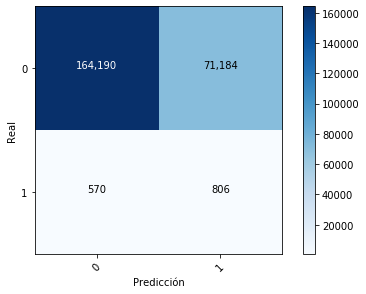

In [77]:
cm_rf_rus_pca = confusion_matrix(y_test, y_pred_rf_rus_pca)  

plot_confusion_matrix_custom(cm_rf_rus_pca, False)

Accuracy:   69.69208025343188
Precision:  1.1195999444367273
Recall:     58.57558139534884
F1 score:   2.197203064089633
MCC:        4.6818086735620525


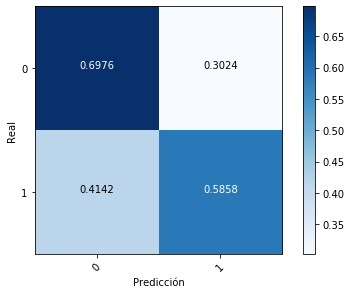

In [78]:
plot_confusion_matrix_custom(cm_rf_rus_pca, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_pca)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_pca)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_pca)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_pca)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_pca)*100) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos PCA y SMOTE
</div>

In [79]:
rf_cfl_sm_pca = rf_clf.fit(X_train_sm_pca, y_train_sm_pca)

In [80]:
y_pred_rf_sm_pca = rf_cfl_sm_pca.predict(X_test_pca)

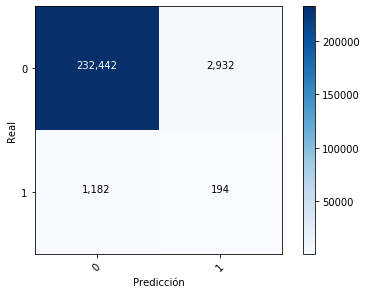

In [81]:
cm_rf_sm_pca = confusion_matrix(y_test, y_pred_rf_sm_pca)  

plot_confusion_matrix_custom(cm_rf_sm_pca,False)

Accuracy:   98.2623020063358
Precision:  6.206014075495841
Recall:     14.098837209302326
F1 score:   8.618391825855177
MCC:        8.559436297184718


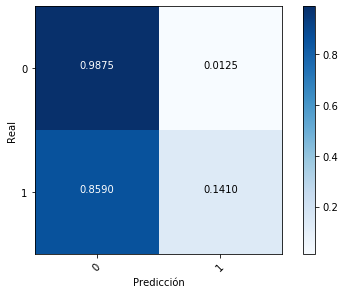

In [82]:
plot_confusion_matrix_custom(cm_rf_sm_pca,True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_sm_pca)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_sm_pca)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_sm_pca)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_sm_pca)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_sm_pca)*100) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos PCA y RandomUnderSampler + SMOTE (1:15)
</div>

In [83]:
rf_cfl_rus_sm_pca_15 = rf_clf.fit(X_train_rus_sm_pca_15, y_train_rus_sm_pca_15)

In [84]:
y_pred_rf_rus_sm_pca_15 = rf_cfl_rus_sm_pca_15.predict(X_test_pca)

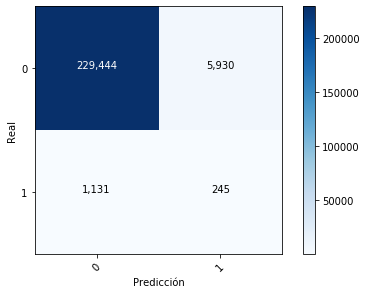

In [85]:
cm_rf_rus_sm_pca_15 = confusion_matrix(y_test, y_pred_rf_rus_sm_pca_15)  

plot_confusion_matrix_custom(cm_rf_rus_sm_pca_15, False)

Accuracy:   97.01752903907075
Precision:  3.967611336032389
Recall:     17.805232558139537
F1 score:   6.48920672758575
MCC:        7.290429604623238


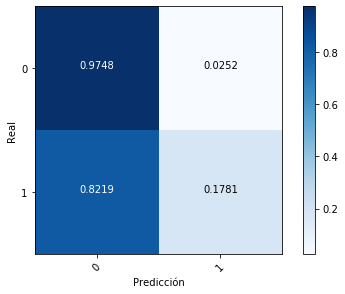

In [86]:
plot_confusion_matrix_custom(cm_rf_rus_sm_pca_15, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_sm_pca_15)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_sm_pca_15)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_sm_pca_15)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_sm_pca_15)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_sm_pca_15)*100) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos PCA y RandomUnderSampler + SMOTE (1:50)
</div>

In [87]:
rf_cfl_rus_sm_pca_50 = rf_clf.fit(X_train_rus_sm_pca_50, y_train_rus_sm_pca_50)

In [88]:
y_pred_rf_rus_sm_pca_50 = rf_cfl_rus_sm_pca_50.predict(X_test_pca)

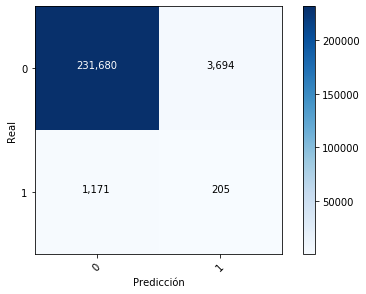

In [89]:
cm_rf_rus_sm_pca_50 = confusion_matrix(y_test, y_pred_rf_rus_sm_pca_50)  

plot_confusion_matrix_custom(cm_rf_rus_sm_pca_50, False)

Accuracy:   97.94508975712776
Precision:  5.257758399589639
Recall:     14.898255813953487
F1 score:   7.772511848341232
MCC:        7.960953729162772


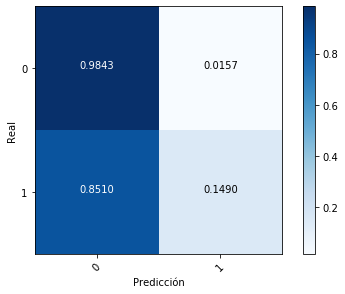

In [90]:
plot_confusion_matrix_custom(cm_rf_rus_sm_pca_50, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_sm_pca_50)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_sm_pca_50)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_sm_pca_50)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_sm_pca_50)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_sm_pca_50)*100) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos XGBoost y RandomUnderSampler
</div>

In [91]:
rf_cfl_rus_xgb = rf_clf.fit(X_train_rus_xgb, y_train_rus_xgb)

In [92]:
y_pred_rf_rus_xgb = rf_cfl_rus_xgb.predict(X_test_xgb)

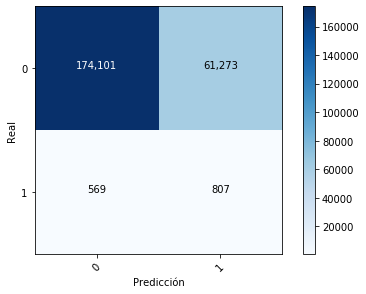

In [93]:
cm_rf_rus_xgb = confusion_matrix(y_test, y_pred_rf_rus_xgb)  

plot_confusion_matrix_custom(cm_rf_rus_xgb, False)

Accuracy:   73.87877507919747
Precision:  1.2999355670103094
Recall:     58.64825581395349
F1 score:   2.543494704992436
MCC:        5.6368315989842195


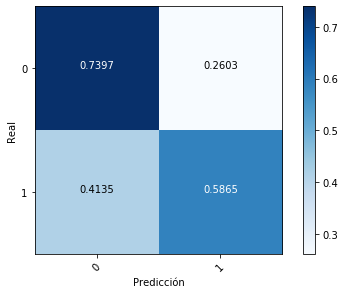

In [94]:
plot_confusion_matrix_custom(cm_rf_rus_xgb, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_xgb)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_xgb)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_xgb)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_xgb)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_xgb)*100) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos XGBoost y SMOTE
</div>

In [95]:
rf_cfl_sm_xgb = rf_clf.fit(X_train_sm_xgb, y_train_sm_xgb)

In [96]:
y_pred_rf_sm_xgb = rf_cfl_sm_xgb.predict(X_test_xgb)

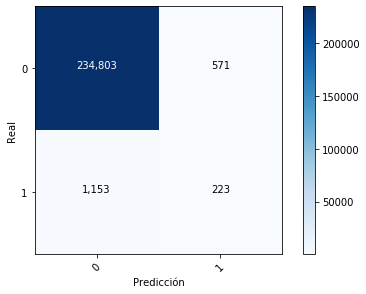

In [97]:
cm_rf_sm_xgb = confusion_matrix(y_test, y_pred_rf_sm_xgb)  

plot_confusion_matrix_custom(cm_rf_sm_xgb, False)

Accuracy:   99.27180570221753
Precision:  28.085642317380355
Recall:     16.206395348837212
F1 score:   20.55299539170507
MCC:        20.989352870237113


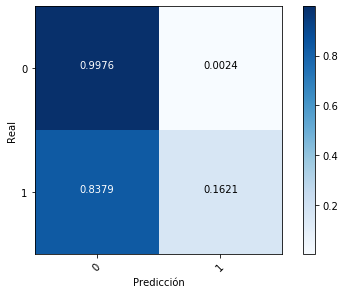

In [98]:
plot_confusion_matrix_custom(cm_rf_sm_xgb, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_sm_xgb)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_sm_xgb)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_sm_xgb)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_sm_xgb)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_sm_xgb)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos XGBoost y RandomUnderSampler + SMOTE (1:15)
</div>

In [99]:
rf_cfl_rus_sm_xgb_15 = rf_clf.fit(X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15)

In [100]:
y_pred_rf_rus_sm_xgb_15 = rf_cfl_rus_sm_xgb_15.predict(X_test_xgb)

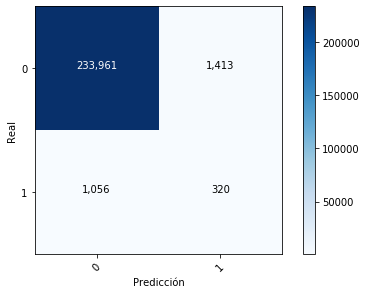

In [101]:
cm_rf_rus_sm_xgb_15 = confusion_matrix(y_test, y_pred_rf_rus_sm_xgb_15)  

plot_confusion_matrix_custom(cm_rf_rus_sm_xgb_15, False)

Accuracy:   98.9571277719113
Precision:  18.465089440276977
Recall:     23.25581395348837
F1 score:   20.585397233837245
MCC:        20.202869246535553


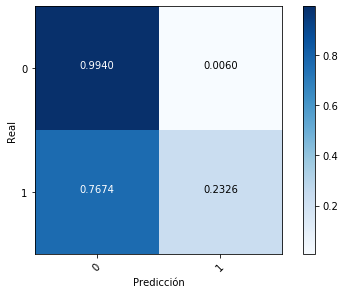

In [102]:
plot_confusion_matrix_custom(cm_rf_rus_sm_xgb_15, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_sm_xgb_15)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_sm_xgb_15)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_sm_xgb_15)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_sm_xgb_15)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_sm_xgb_15)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    Ramdom Forest con el conjunto de datos XGBoost y RandomUnderSampler + SMOTE (1:50)
</div>

In [103]:
rf_cfl_rus_sm_xgb_50 = rf_clf.fit(X_train_rus_sm_xgb_50, y_train_rus_sm_xgb_50)

In [104]:
y_pred_rf_rus_sm_xgb_50 = rf_cfl_rus_sm_xgb_50.predict(X_test_xgb)

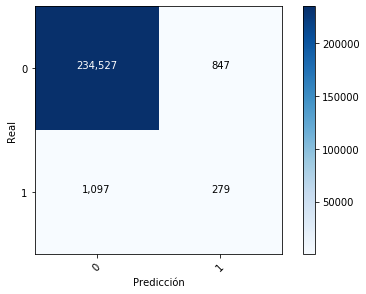

In [105]:
cm_rf_rus_sm_xgb_50 = confusion_matrix(y_test, y_pred_rf_rus_sm_xgb_50)  

plot_confusion_matrix_custom(cm_rf_rus_sm_xgb_50, False)

Accuracy:   99.17888067581838
Precision:  24.77797513321492
Recall:     20.276162790697676
F1 score:   22.30215827338129
MCC:        22.00484836030922


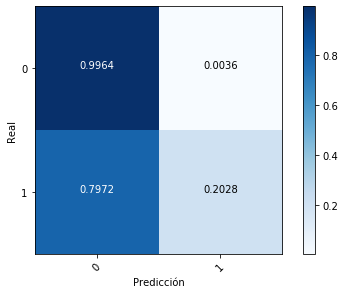

In [106]:
plot_confusion_matrix_custom(cm_rf_rus_sm_xgb_50, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_rf_rus_sm_xgb_50)*100)  
print('Precision: ', precision_score(y_test,y_pred_rf_rus_sm_xgb_50)*100)  
print('Recall:    ', recall_score(y_test,y_pred_rf_rus_sm_xgb_50)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_rf_rus_sm_xgb_50)*100)  
print('MCC:       ', matthews_corrcoef(y_test,y_pred_rf_rus_sm_xgb_50)*100)

## 4.2. eXtreme Gradient Boosting (XGBoost)

### 4.2.1. Hiperparámetros

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
En el sistema de Boosting se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Para decidir cuáles son los hiperparámetros óptimos se utiliza una búsqueda de rejilla (grid search), es decir, se entrena un modelo para cada combinación de hiperparámetros posible y se evalua utilizando validación cruzada (cross validation) con 3 particiones estratificadas. 
Posteriormente se selecciona la combinación de hiperparámetros que mejor resultados haya dado.
</div>

In [107]:
param_grid = {
    "n_estimators"     : [50, 100, 200],
    "max_depth"        : [8, 10, 20],
    "min_child_weight" : [6, 8, 10],
    "random_state"     : [2020],
}

xgb_clf_gs = GridSearchCV(XGBClassifier(), param_grid=param_grid, scoring='f1', cv=3, pre_dispatch=6, n_jobs=3, verbose=0)

In [108]:
# Se toma como conjunto de entrenamiento para determinar los mejores parámetros los resultantes de PCA + combinar los muestreos 
xgb_clf_gs_rus_sm_pca_15 = xgb_clf_gs.fit(X_train_rus_sm_pca_15, y_train_rus_sm_pca_15)

In [109]:
xgb_clf_gs_rus_sm_pca_15.best_params_

{'max_depth': 20,
 'min_child_weight': 6,
 'n_estimators': 200,
 'random_state': 2020}

In [110]:
means = xgb_clf_gs_rus_sm_pca_15.cv_results_["mean_test_score"]
stds = xgb_clf_gs_rus_sm_pca_15.cv_results_["std_test_score"]
params = xgb_clf_gs_rus_sm_pca_15.cv_results_['params']
ranks = xgb_clf_gs_rus_sm_pca_15.cv_results_['rank_test_score']

for rank, mean, std, pms in zip(ranks, means, stds, params):
    print("{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(rank, mean*100, std*100, pms))

25) Precisión media: 88.29 +/- 1.41 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 50, 'random_state': 2020}
19) Precisión media: 93.07 +/- 1.38 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'random_state': 2020}
14) Precisión media: 96.10 +/- 1.15 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 200, 'random_state': 2020}
26) Precisión media: 87.98 +/- 1.49 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 50, 'random_state': 2020}
21) Precisión media: 92.87 +/- 1.45 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 100, 'random_state': 2020}
16) Precisión media: 95.87 +/- 1.24 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 200, 'random_state': 2020}
27) Precisión media: 87.84 +/- 1.49 con parámetros {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 50, 'random_state': 2020}
23) Precisión media: 92.66 +/- 1.54 con parámetros {'max_depth':

In [111]:
# Se toma como conjunto de entrenamiento para determinar los mejores parámetros los resultantes de XGB + combinar los muestreos 
xgb_clf_gs_rus_sm_xgb_15 = xgb_clf_gs.fit(X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15)

In [112]:
xgb_clf_gs_rus_sm_xgb_15.best_params_

{'max_depth': 20,
 'min_child_weight': 6,
 'n_estimators': 50,
 'random_state': 2020}

In [113]:
means = xgb_clf_gs_rus_sm_xgb_15.cv_results_["mean_test_score"]
stds = xgb_clf_gs_rus_sm_xgb_15.cv_results_["std_test_score"]
params = xgb_clf_gs_rus_sm_xgb_15.cv_results_['params']
ranks = xgb_clf_gs_rus_sm_xgb_15.cv_results_['rank_test_score']

for rank, mean, std, pms in zip(ranks, means, stds, params):
    print("{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(rank, mean*100, std*100, pms))

26) Precisión media: 95.21 +/- 4.42 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 50, 'random_state': 2020}
19) Precisión media: 96.03 +/- 4.54 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'random_state': 2020}
13) Precisión media: 96.37 +/- 4.51 con parámetros {'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 200, 'random_state': 2020}
25) Precisión media: 95.26 +/- 4.44 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 50, 'random_state': 2020}
20) Precisión media: 95.97 +/- 4.54 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 100, 'random_state': 2020}
15) Precisión media: 96.32 +/- 4.54 con parámetros {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 200, 'random_state': 2020}
27) Precisión media: 95.13 +/- 4.34 con parámetros {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 50, 'random_state': 2020}
21) Precisión media: 95.94 +/- 4.57 con parámetros {'max_depth':

### 4.1.2. Ejecución inicial

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
A partir de los conjuntos de datos obtenidos de la reducción dimensional y el muestreo, se entrena un modelo <i>XGBoost</i> con los mejores parámetros obtenidos del <i>grid search</i>.
</div>

In [114]:
xgb_clf = XGBClassifier(n_estimators=xgb_clf_gs_rus_sm_pca_15.best_params_["n_estimators"], max_depth=xgb_clf_gs_rus_sm_pca_15.best_params_["max_depth"], min_child_weight=xgb_clf_gs_rus_sm_pca_15.best_params_["min_child_weight"], random_state=xgb_clf_gs_rus_sm_pca_15.best_params_["random_state"], subsample=0.8, scoring='f1', cv=3, pre_dispatch=6, n_jobs=3, verbose=0)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos PCA y RandomUnderSampler
</div>

In [115]:
xgb_cfl_rus_pca = xgb_clf.fit(X_train_rus_pca, y_train_rus_pca)

In [116]:
y_pred_xgb_rus_pca = xgb_cfl_rus_pca.predict(X_test_pca)

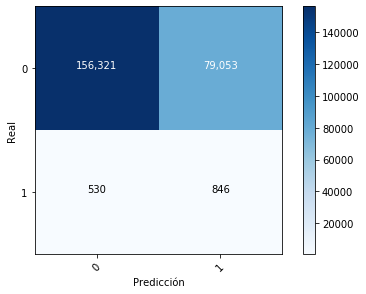

In [117]:
cm_xgb_rus_pca = confusion_matrix(y_test, y_pred_xgb_rus_pca)  

plot_confusion_matrix_custom(cm_xgb_rus_pca, False)

Accuracy:   66.38521647307286
Precision:  1.0588367814365638
Recall:     61.48255813953488
F1 score:   2.081820978160566
MCC:        4.484591189664204


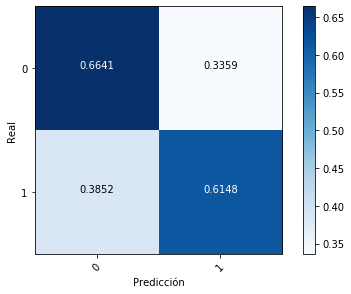

In [118]:
plot_confusion_matrix_custom(cm_xgb_rus_pca, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_pca)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_pca)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_pca)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_pca)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_pca)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos PCA y SMOTE
</div>

In [119]:
xgb_cfl_sm_pca = xgb_clf.fit(X_train_sm_pca, y_train_sm_pca)

In [120]:
y_pred_xgb_sm_pca = xgb_cfl_sm_pca.predict(X_test_pca)

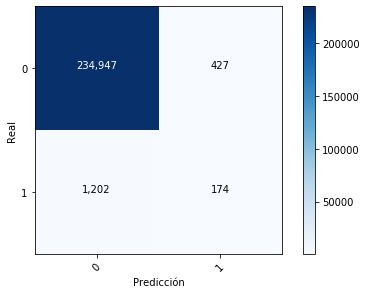

In [121]:
cm_xgb_sm_pca = confusion_matrix(y_test, y_pred_xgb_sm_pca)  

plot_confusion_matrix_custom(cm_xgb_sm_pca, False)

Accuracy:   99.31193241816261
Precision:  28.95174708818636
Recall:     12.645348837209303
F1 score:   17.602427921092563
MCC:        18.8283975601589


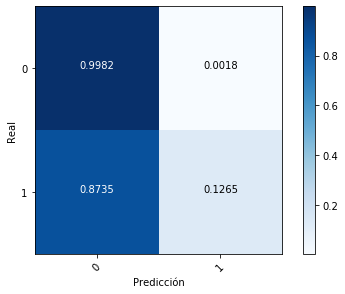

In [122]:
plot_confusion_matrix_custom(cm_xgb_sm_pca, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_sm_pca)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_sm_pca)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_sm_pca)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_sm_pca)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_sm_pca)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos PCA y RandomUnderSampler + SMOTE (1:15)
</div>

In [123]:
xgb_cfl_rus_sm_pca_15 = xgb_clf.fit(X_train_rus_sm_pca_15, y_train_rus_sm_pca_15)

In [124]:
y_pred_xgb_rus_sm_pca_15 = xgb_cfl_rus_sm_pca_15.predict(X_test_pca)

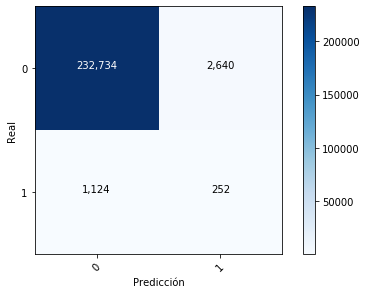

In [125]:
cm_xgb_rus_sm_pca_15 = confusion_matrix(y_test, y_pred_xgb_rus_sm_pca_15)  

plot_confusion_matrix_custom(cm_xgb_rus_sm_pca_15, False)

Accuracy:   98.41013727560718
Precision:  8.71369294605809
Recall:     18.313953488372093
F1 score:   11.808809746954074
MCC:        11.89728999909365


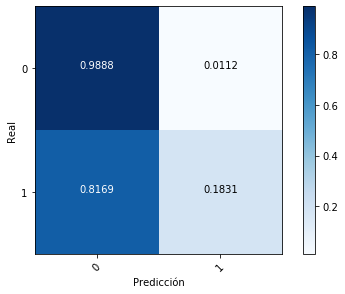

In [126]:
plot_confusion_matrix_custom(cm_xgb_rus_sm_pca_15, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_sm_pca_15)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_sm_pca_15)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_sm_pca_15)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_sm_pca_15)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_sm_pca_15)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos PCA y RandomUnderSampler + SMOTE (1:50)
</div>

In [127]:
xgb_cfl_rus_sm_pca_50 = xgb_clf.fit(X_train_rus_sm_pca_50, y_train_rus_sm_pca_50)

In [128]:
y_pred_xgb_rus_sm_pca_50 = xgb_cfl_rus_sm_pca_50.predict(X_test_pca)

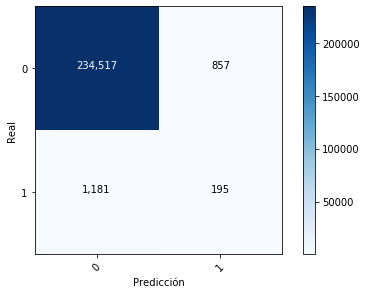

In [129]:
cm_xgb_rus_sm_pca_50 = confusion_matrix(y_test, y_pred_xgb_rus_sm_pca_50)  

plot_confusion_matrix_custom(cm_xgb_rus_sm_pca_50, False)

Accuracy:   99.13917634635692
Precision:  18.5361216730038
Recall:     14.171511627906977
F1 score:   16.062602965403624
MCC:        15.78028603251099


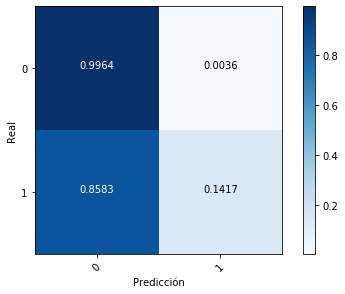

In [130]:
plot_confusion_matrix_custom(cm_xgb_rus_sm_pca_50, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_sm_pca_50)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_sm_pca_50)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_sm_pca_50)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_sm_pca_50)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_sm_pca_50)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos XGBoost y RandomUnderSampler
</div>

In [131]:
xgb_cfl_rus_xgb = xgb_clf.fit(X_train_rus_xgb, y_train_rus_xgb)

In [132]:
y_pred_xgb_rus_xgb = xgb_cfl_rus_xgb.predict(X_test_xgb)

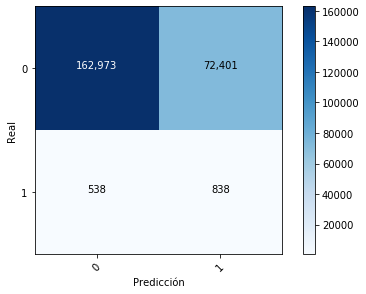

In [133]:
cm_xgb_rus_xgb = confusion_matrix(y_test, y_pred_xgb_rus_xgb)  

plot_confusion_matrix_custom(cm_xgb_rus_xgb, False)

Accuracy:   69.19155227032735
Precision:  1.1441991288794222
Recall:     60.90116279069767
F1 score:   2.24619714534611
MCC:        4.956830094404631


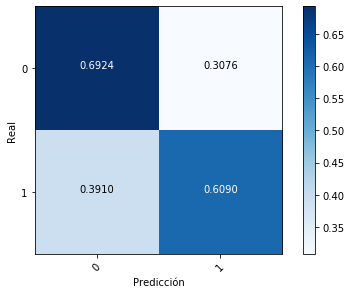

In [134]:
plot_confusion_matrix_custom(cm_xgb_rus_xgb, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_xgb)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_xgb)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_xgb)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_xgb)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_xgb)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos XGBoost y SMOTE
</div>

In [135]:
xgb_cfl_sm_xgb = xgb_clf.fit(X_train_sm_xgb, y_train_sm_xgb)

In [136]:
y_pred_xgb_sm_xgb = xgb_cfl_sm_xgb.predict(X_test_xgb)

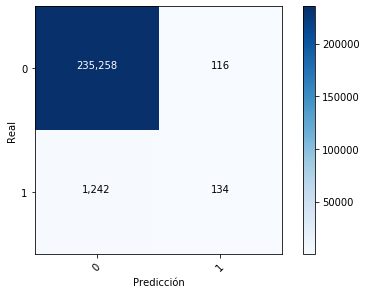

In [137]:
cm_xgb_sm_xgb = confusion_matrix(y_test, y_pred_xgb_sm_xgb)  

plot_confusion_matrix_custom(cm_xgb_sm_xgb, False)

Accuracy:   99.42639915522703
Precision:  53.6
Recall:     9.738372093023257
F1 score:   16.482164821648215
MCC:        22.677011554561304


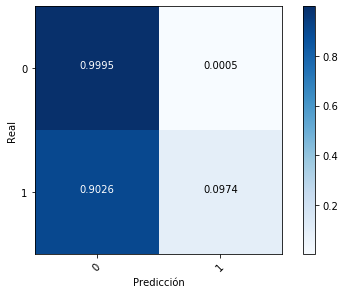

In [138]:
plot_confusion_matrix_custom(cm_xgb_sm_xgb, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_sm_xgb)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_sm_xgb)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_sm_xgb)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_sm_xgb)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_sm_xgb)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos XGBoost y y RandomUnderSampler + SMOTE (1:15)
</div>

In [139]:
xgb_cfl_rus_sm_xgb_15 = xgb_clf.fit(X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15)

In [140]:
y_pred_xgb_rus_sm_xgb_15 = xgb_cfl_rus_sm_xgb_15.predict(X_test_xgb)

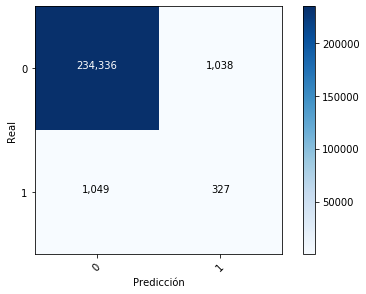

In [141]:
cm_xgb_rus_sm_xgb_15 = confusion_matrix(y_test, y_pred_xgb_rus_sm_xgb_15)  

plot_confusion_matrix_custom(cm_xgb_rus_sm_xgb_15, False)

Accuracy:   99.11847940865893
Precision:  23.956043956043956
Recall:     23.76453488372093
F1 score:   23.85990514410799
MCC:        23.416776467152797


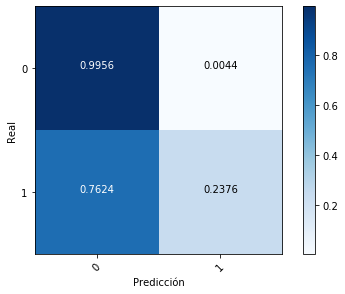

In [142]:
plot_confusion_matrix_custom(cm_xgb_rus_sm_xgb_15, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_sm_xgb_15)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_sm_xgb_15)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_sm_xgb_15)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_sm_xgb_15)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_sm_xgb_15)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">    
    XGBoost con el conjunto de datos XGBoost y y RandomUnderSampler + SMOTE (1:50)
</div>

In [143]:
xgb_cfl_rus_sm_xgb_50 = xgb_clf.fit(X_train_rus_sm_xgb_50, y_train_rus_sm_xgb_50)

In [144]:
y_pred_xgb_rus_sm_xgb_50 = xgb_cfl_rus_sm_xgb_50.predict(X_test_xgb)

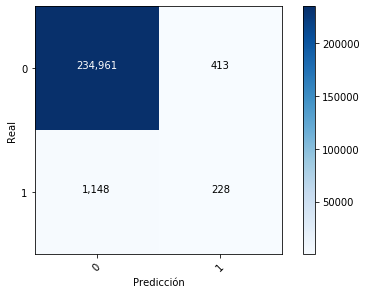

In [145]:
cm_xgb_rus_sm_xgb_50 = confusion_matrix(y_test, y_pred_xgb_rus_sm_xgb_50)  

plot_confusion_matrix_custom(cm_xgb_rus_sm_xgb_50, False)

Accuracy:   99.34065469904964
Precision:  35.569422776911075
Recall:     16.569767441860463
F1 score:   22.607833415964304
MCC:        23.9825913034071


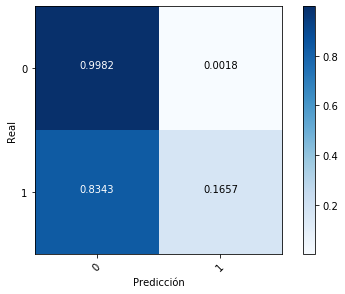

In [146]:
plot_confusion_matrix_custom(cm_xgb_rus_sm_xgb_50, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_xgb_rus_sm_xgb_50)*100)  
print('Precision: ', precision_score(y_test,y_pred_xgb_rus_sm_xgb_50)*100)  
print('Recall:    ', recall_score(y_test,y_pred_xgb_rus_sm_xgb_50)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_xgb_rus_sm_xgb_50)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_xgb_rus_sm_xgb_50)*100)

# 5. Evaluación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> 
En base a estos resultados, cabe la pregunta de: dato que se están utilizando dos modelos diferentes, si se combinan, ¿mejora algo? 

En este apartado se explora dentro de la combinación secuencial de modelos la técnica del stacking para obtener un clasificador combinando de ambos modelos ya utilizados.

</div>

## 5.1. Combinación secuencial de modelos stacking

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> 
El stacking es una técnica de combinación secuencial de clasificadores bases diferentes a través de un meta-clasificador.

En el caso concreto de este trabajo y por las limitaciones de recursos, se entrena el clasificador de stacking utilizando los conjuntos de datos de la combinación de muestreo con ratio 1:15 y ratio 1:50 del número de positivos para los clasificadores empleados en la etapa del modelado.

</div>

In [147]:
# Se combinan los clasificadores en un mismo meta-clasificador 

estimators = [
     ('rf', ensemble.RandomForestClassifier(n_estimators=rf_clf_gs_rus_sm_pca_15.best_params_["n_estimators"], max_depth=rf_clf_gs_rus_sm_pca_15.best_params_["max_depth"], random_state=rf_clf_gs_rus_sm_pca_15.best_params_["random_state"], n_jobs=3, verbose=0)),
     ('xgb', XGBClassifier(n_estimators=xgb_clf_gs_rus_sm_pca_15.best_params_["n_estimators"], max_depth=xgb_clf_gs_rus_sm_pca_15.best_params_["max_depth"], random_state=xgb_clf_gs_rus_sm_pca_15.best_params_["random_state"], min_child_weight=xgb_clf_gs_rus_sm_xgb_15.best_params_["min_child_weight"], subsample=0.8, scoring='f1', cv=3, pre_dispatch=6, n_jobs=3, verbose=0))
 ]

stack_clf = StackingClassifier(estimators=estimators, cv=3, n_jobs=3, verbose=0)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> 
Ratio 1:15
</div>

In [148]:
stack_cfl_rus_sm_xgb_15 = stack_clf.fit(X_train_rus_sm_xgb_15, y_train_rus_sm_xgb_15)

In [149]:
y_pred_stack_rus_sm_xgb_15 = stack_cfl_rus_sm_xgb_15.predict(X_test_xgb)

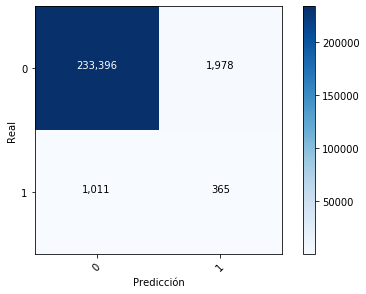

In [150]:
cm_stack_rus_sm_xgb_15 = confusion_matrix(y_test, y_pred_stack_rus_sm_xgb_15)  

plot_confusion_matrix_custom(cm_stack_rus_sm_xgb_15, False)

Accuracy:   98.73748680042239
Precision:  15.578318395219803
Recall:     26.526162790697676
F1 score:   19.62893250873891
MCC:        19.724685742607747


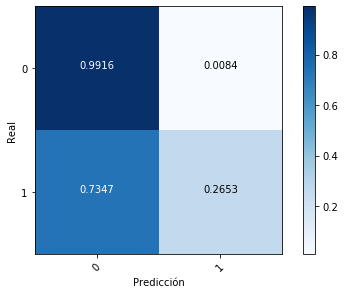

In [151]:
plot_confusion_matrix_custom(cm_stack_rus_sm_xgb_15, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_stack_rus_sm_xgb_15)*100)  
print('Precision: ', precision_score(y_test,y_pred_stack_rus_sm_xgb_15)*100)  
print('Recall:    ', recall_score(y_test,y_pred_stack_rus_sm_xgb_15)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_stack_rus_sm_xgb_15)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_stack_rus_sm_xgb_15)*100)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> 
Ratio 1:50
</div>

In [152]:
stack_cfl_rus_sm_xgb_50 = stack_clf.fit(X_train_rus_sm_xgb_50, y_train_rus_sm_xgb_50)

In [153]:
y_pred_stack_rus_sm_xgb_50 = stack_cfl_rus_sm_xgb_50.predict(X_test_xgb)

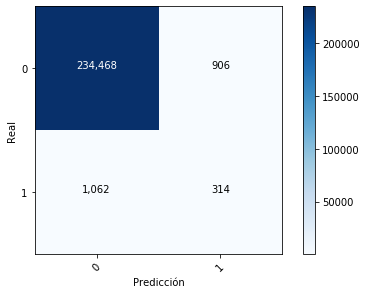

In [154]:
cm_stack_rus_sm_xgb_50 = confusion_matrix(y_test, y_pred_stack_rus_sm_xgb_50)  

plot_confusion_matrix_custom(cm_stack_rus_sm_xgb_50, False)

Accuracy:   99.16874340021118
Precision:  25.73770491803279
Recall:     22.819767441860463
F1 score:   24.191063174114024
MCC:        23.818179469922455


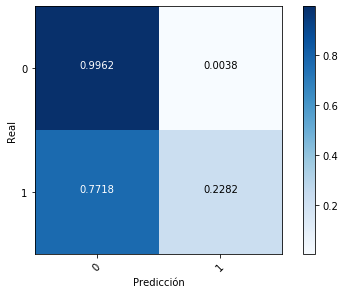

In [155]:
plot_confusion_matrix_custom(cm_stack_rus_sm_xgb_50, True)

print('Accuracy:  ', accuracy_score(y_test,y_pred_stack_rus_sm_xgb_50)*100)  
print('Precision: ', precision_score(y_test,y_pred_stack_rus_sm_xgb_50)*100)  
print('Recall:    ', recall_score(y_test,y_pred_stack_rus_sm_xgb_50)*100)  
print('F1 score:  ', f1_score(y_test,y_pred_stack_rus_sm_xgb_50)*100)
print('MCC:       ', matthews_corrcoef(y_test,y_pred_stack_rus_sm_xgb_50)*100)